In [14]:
import os
import pickle
import openslide
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from tqdm import tqdm

In [15]:

# Define paths
output_results_dir = "results/"
test_images_dir = "/Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/test/images"
xml_annotations_dir = "/Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/test/lesion_annotations"

In [16]:
def parse_xml_annotations(xml_file):
    """Parses XML annotations to extract tumor regions."""
    if not os.path.exists(xml_file):
        print(f"Warning: Missing annotation file {xml_file}")
        return []

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    annotations = []
    for annotation in root.findall(".//Annotation"):
        coords = []
        for coord in annotation.findall(".//Coordinate"):
            x = float(coord.attrib["X"])
            y = float(coord.attrib["Y"])
            coords.append((x, y))
        annotations.append(np.array(coords))
    
    return annotations

In [17]:
# Load predictions
with open(os.path.join(output_results_dir, "tile_predictions.pkl"), "rb") as f:
    tile_predictions_dict = pickle.load(f)

# Allow user to pick a slide
print("Available slides:")
for slide_name in tile_predictions_dict.keys():
    print(slide_name)

selected_slide = input("Enter the name of the slide to visualize: ")
if selected_slide not in tile_predictions_dict:
    raise ValueError("Selected slide not found in predictions.")

Available slides:
test_001.tif
test_002.tif
test_003.tif


In [18]:

slide_path = os.path.join(test_images_dir, selected_slide)
xml_path = os.path.join(xml_annotations_dir, f"{os.path.splitext(selected_slide)[0]}.xml")
slide = openslide.OpenSlide(slide_path)
ground_truth_annotations = parse_xml_annotations(xml_path)
tile_predictions = tile_predictions_dict[selected_slide]


In [19]:
def plot_slide_with_overlay():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    downsample_level = 6
    ds_slide = slide.get_thumbnail((slide.dimensions[0] // downsample_level, slide.dimensions[1] // downsample_level))
    
    axes[0].imshow(ds_slide)
    axes[0].set_title("Downsampled Slide")
    axes[0].axis('off')
    
    axes[1].imshow(ds_slide)
    for annotation in ground_truth_annotations:
        poly = Polygon(annotation / downsample_level, edgecolor='red', facecolor='none', linewidth=2)
        axes[1].add_patch(poly)
    axes[1].set_title("Ground Truth Annotations")
    axes[1].axis('off')
    
    axes[2].imshow(ds_slide)
    for (x, y, pred) in tile_predictions:
        color = 'red' if pred == 1 else 'blue'
        rect = Rectangle((x / downsample_level, y / downsample_level), 256 / downsample_level, 256 / downsample_level, linewidth=1, edgecolor=color, facecolor=color, alpha=0.3)
        axes[2].add_patch(rect)
    axes[2].set_title("Predictions Overlay")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_results_dir, f"{selected_slide}_overlay.png"))
    plt.show()




In [21]:
from skimage.transform import resize

def plot_slide_with_overlay():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    downsample_level = len(slide.level_downsamples) - 1
    slide_width, slide_height = slide.dimensions
    ds_width, ds_height = slide_width // downsample_level, slide_height // downsample_level
    ds_slide = slide.get_thumbnail((ds_width, ds_height))
    
    axes[0].imshow(ds_slide)
    axes[0].set_title("Downsampled Slide")
    axes[0].axis('off')
    
    axes[1].imshow(ds_slide)
    for annotation in ground_truth_annotations:
        poly = Polygon(annotation / downsample_level, edgecolor='red', facecolor='none', linewidth=2)
        axes[1].add_patch(poly)
    axes[1].set_title("Ground Truth Annotations")
    axes[1].axis('off')
    
    # Generate an empty heatmap the size of the slide (downsampled)
    heatmap = np.zeros((ds_height, ds_width))
    tile_size = 256 // downsample_level
    
    # Populate the heatmap with prediction scores
    for (x, y, pred_prob) in tile_predictions:  # assuming pred_prob is in [0,1]
        x_idx, y_idx = int(x / downsample_level), int(y / downsample_level)
        heatmap[y_idx:y_idx+tile_size, x_idx:x_idx+tile_size] = pred_prob  # Assign probability to corresponding region
    
    # Resize the heatmap to match the downsampled slide dimensions
    heatmap_resized = resize(heatmap, (ds_height, ds_width), mode='reflect', anti_aliasing=True)
    
    # Overlay the heatmap using colormap and transparency
    axes[2].imshow(ds_slide)
    axes[2].imshow(heatmap_resized, cmap='jet', alpha=0.5)  # Adjust alpha for transparency
    axes[2].set_title("Predictions Heatmap")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_results_dir, f"{selected_slide}_overlay.png"))
    plt.show()


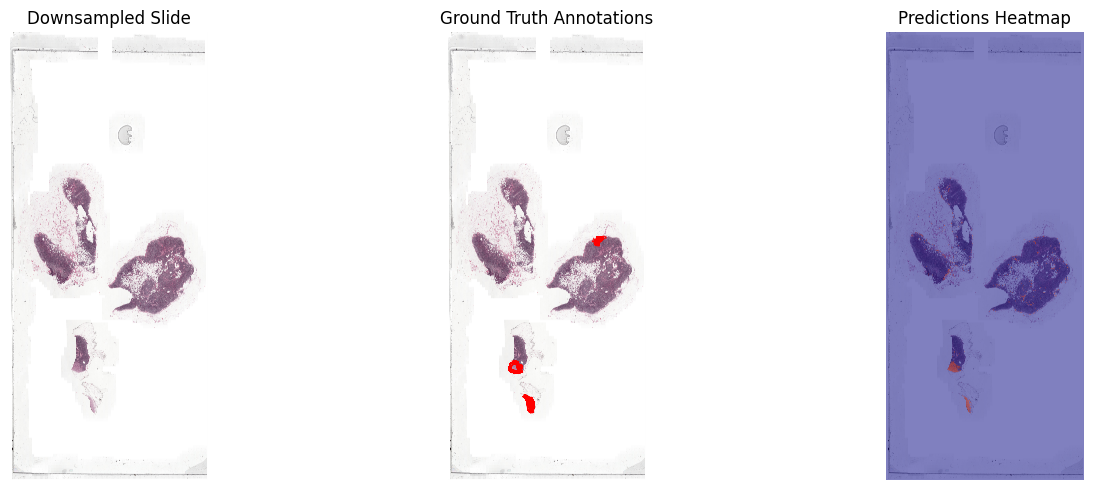

In [22]:
plot_slide_with_overlay()